In [19]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow import keras

In [20]:
dataset = 'model/gesture.csv'
model_save_path = 'model/gesture_classifier/gesture_classifier.keras'
tflite_save_path = 'model/gesture_classifier/gesture_classifier.tflite'
labels = 'model/gesture_classifier_label.csv'

In [21]:
def count_words_in_csv(filename):
  total_words = 0
  with open(filename, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
      # Count words in each row (assuming comma separation)
      num_words = sum(1 for word in row if word.strip())  # Count non-empty words
      total_words += num_words
  return total_words


In [22]:
n_classes = count_words_in_csv(labels)

In [23]:
#X = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
#y = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X = pd.read_csv(dataset, usecols=list(range(1, (21 * 2) + 1)))
X.fillna(0, inplace=True)
X = X.astype(float)

y = pd.read_csv(dataset, usecols=[0])


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [25]:
def create_model(n_classes):
    inputs = keras.Input(shape=(21 * 2,))
    x = keras.layers.Dropout(0.2)(inputs)
    x = keras.layers.Dense(20, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(10, activation='relu')(x)
    outputs = keras.layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
model = create_model(n_classes)  # Assuming n_classes is 10

In [26]:
model.summary() 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103 (4.31 KB)

 Trainable params: 1,103 (4.31 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [28]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.3516 - loss: 1.0974
Epoch 1: saving model to model/gesture_classifier/gesture_classifier.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - accuracy: 0.3407 - loss: 1.0985 - val_accuracy: 0.1754 - val_loss: 1.1367
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3828 - loss: 1.1000
Epoch 2: saving model to model/gesture_classifier/gesture_classifier.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3668 - loss: 1.1000 - val_accuracy: 0.2105 - val_loss: 1.1306
Epoch 3/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3828 - loss: 1.1066
Epoch 3: saving model to model/gesture_classifier/gesture_classifier.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3668 - loss: 1.1045 - val_accuracy: 0.2105 - val_loss: 1.1241
Epoch 4/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3359 - loss: 1.0828
Epoch 4: saving model to model/gesture_classifier/gesture_classifier.keras
2/2 ━━━━━━━━━━━━━━━

In [12]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.1657


In [30]:
model = tf.keras.models.load_model(model_save_path)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


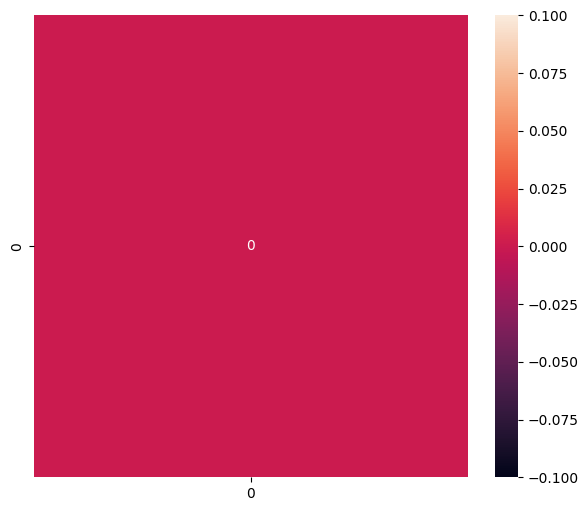

Classification Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      1.00      1.00        26
           2       1.00      0.94      0.97        17

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57



In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [32]:
model.save(model_save_path, include_optimizer=False)

In [33]:
model.export("model/gesture_classifier/saved_model")

INFO:tensorflow:Assets written to: model/gesture_classifier/saved_model\assets


INFO:tensorflow:Assets written to: model/gesture_classifier/saved_model\assets


Saved artifact at 'model/gesture_classifier/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1976362849504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1976362845632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1976362848800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1976362847216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1976362845280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1976362848448: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [34]:
converter = tf.lite.TFLiteConverter.from_saved_model("model/gesture_classifier/saved_model")
tflite_model = converter.convert()
with open(tflite_save_path, "wb") as f:
    f.write(tflite_model)



In [35]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [36]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [37]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

KeyError: 0

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])